# Fraud Detection — Everything Notebook (Gaussian Naive Bayes)

In [1]:

import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from src.data_gen import generate_synthetic_strong

OUT = Path('outputs'); OUT.mkdir(exist_ok=True, parents=True)


## Generate / Load Data

In [2]:

df = generate_synthetic_strong(n_rows=8000, random_state=42)
df.head()


,amount,transaction_freq_24h,account_age_days,is_weekend,risk_score,is_fraud
0,496.36,3,552,1,0.3,0
1,129.36,1,82,0,0.0,0
2,775.13,3,952,1,0.3,0
3,937.44,2,645,0,0.0,0
4,52.02,6,333,1,0.3,0


## EDA — Correlation

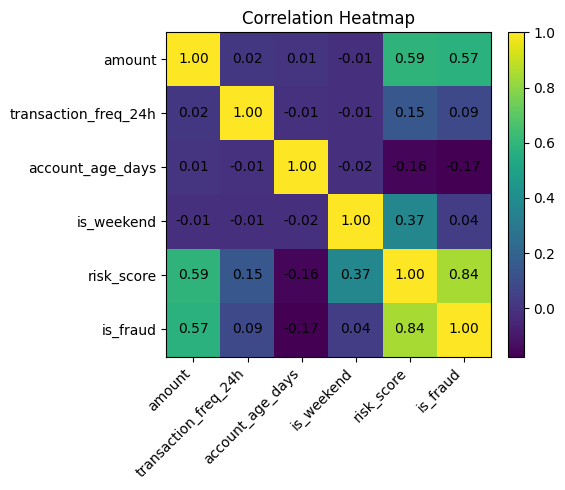

In [3]:

cols=['amount','transaction_freq_24h','account_age_days','is_weekend','risk_score','is_fraud']
corr = df[cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
im = plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha='right')
plt.yticks(range(corr.shape[0]), corr.index)
import numpy as np
for (i,j),v in np.ndenumerate(corr.values):
    plt.text(j, i, f"{v:.2f}", ha='center', va='center')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


## EDA — Distributions & Label Balance

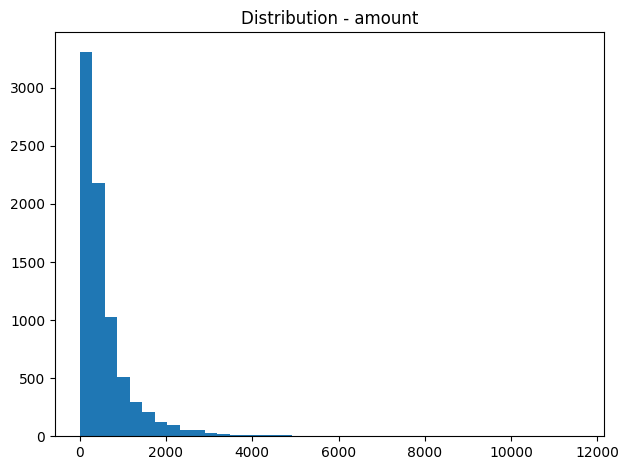

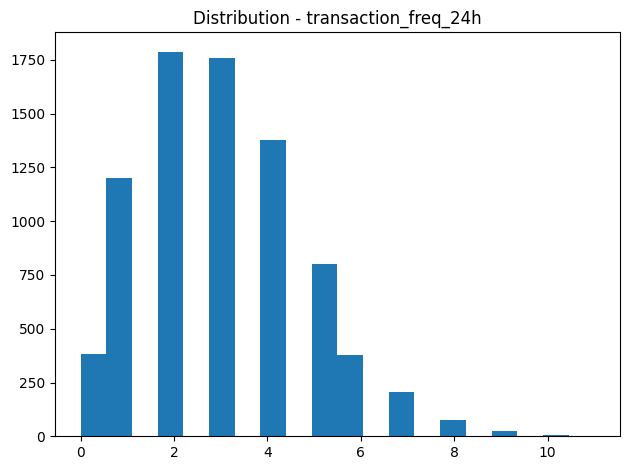

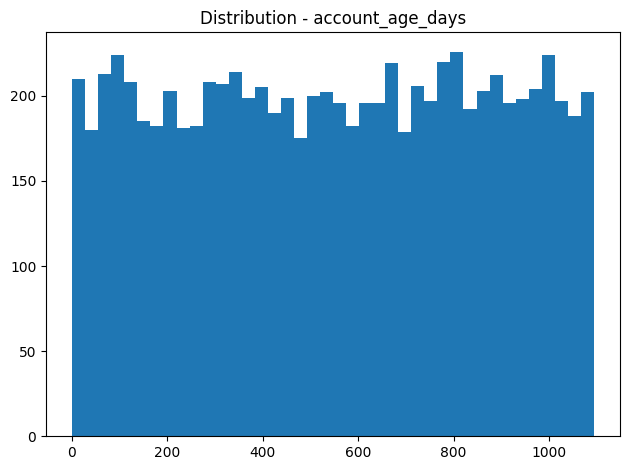

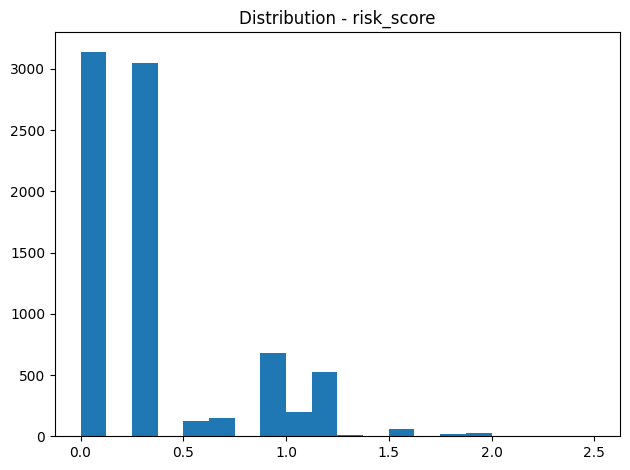

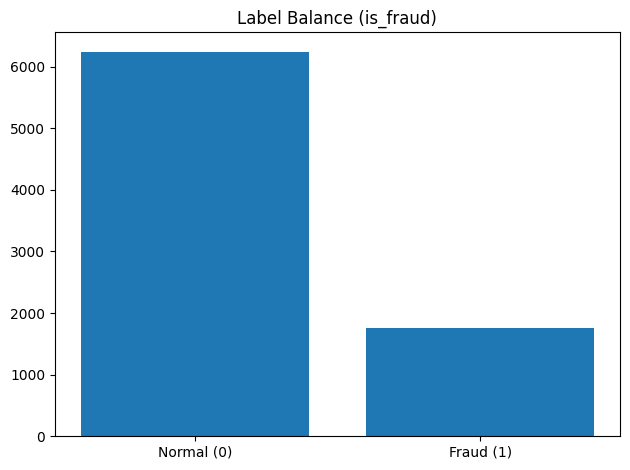

In [4]:

def show_hist(series, title, bins=40):
    plt.figure(); plt.hist(series, bins=bins); plt.title(title); plt.tight_layout(); plt.show()

show_hist(df['amount'], 'Distribution - amount')
show_hist(df['transaction_freq_24h'], 'Distribution - transaction_freq_24h', bins=20)
show_hist(df['account_age_days'], 'Distribution - account_age_days', bins=40)
show_hist(df['risk_score'], 'Distribution - risk_score', bins=20)

# label balance
counts = df['is_fraud'].value_counts().sort_index()
plt.figure(); plt.bar(['Normal (0)', 'Fraud (1)'], counts.values); plt.title('Label Balance (is_fraud)'); plt.tight_layout(); plt.show()


## Split 70:30, Train GaussianNB, Evaluate

Default (thr=0.5):
Acc: 0.9691666666666666
Prec: 0.9297912713472486
Rec : 0.9297912713472486
F1  : 0.9297912713472486
AUC : 0.9582269157943045


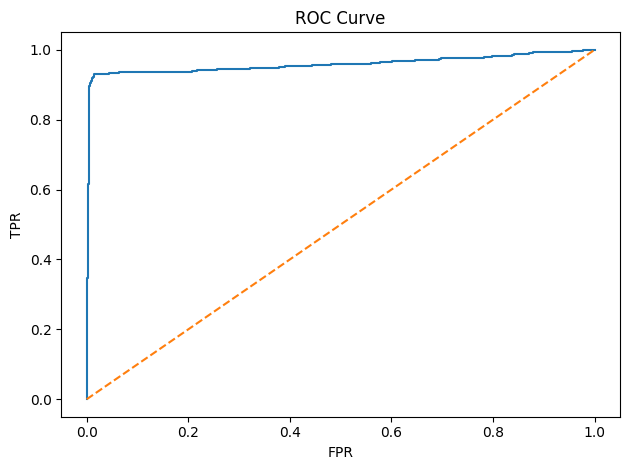

In [5]:

X = df.drop(columns=['is_fraud']).copy(); y = df['is_fraud'].values
X['log_amount'] = np.log1p(X['amount']); X = X.drop(columns=['amount'])
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)
sc=StandardScaler(); Xtr_s=sc.fit_transform(Xtr); Xte_s=sc.transform(Xte)
nb=GaussianNB().fit(Xtr_s,ytr)
y_proba = nb.predict_proba(Xte_s)[:,1]

# default metrics
y_pred_def = (y_proba >= 0.5).astype(int)
print('Default (thr=0.5):')
print('Acc:', accuracy_score(yte,y_pred_def))
print('Prec:', precision_score(yte,y_pred_def, zero_division=0))
print('Rec :', recall_score(yte,y_pred_def, zero_division=0))
print('F1  :', f1_score(yte,y_pred_def, zero_division=0))
print('AUC :', roc_auc_score(yte,y_proba))

# ROC
fpr,tpr,_ = roc_curve(yte,y_proba)
plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.tight_layout(); plt.show()


## Threshold Tuning (Target ≥ 0.75 All Metrics)

Best: {'threshold': 0.05, 'accuracy': 0.95125, 'precision': 0.8583916083916084, 'recall': 0.9316888045540797, 'f1': 0.8935395814376706, 'auc': 0.9582269157943045}


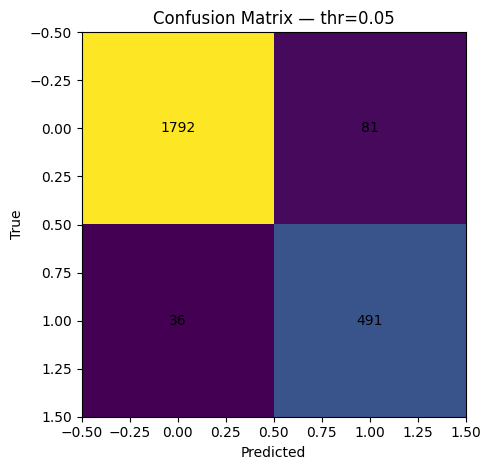

In [6]:

best=None
for thr in np.linspace(0.05,0.95,181):
    y_pred=(y_proba>=thr).astype(int)
    acc=accuracy_score(yte,y_pred); prec=precision_score(yte,y_pred,zero_division=0)
    rec=recall_score(yte,y_pred,zero_division=0); f1=f1_score(yte,y_pred,zero_division=0)
    auc=roc_auc_score(yte,y_proba)
    if acc>=.75 and prec>=.75 and rec>=.75 and f1>=.75:
        best=dict(threshold=float(thr),accuracy=acc,precision=prec,recall=rec,f1=f1,auc=auc); break

print('Best:', best)

# CM at best thr
from sklearn.metrics import confusion_matrix
y_pred_best=(y_proba>=best['threshold']).astype(int)
cm = confusion_matrix(yte, y_pred_best)
plt.figure(); plt.imshow(cm, interpolation='nearest'); plt.title(f'Confusion Matrix — thr={best['threshold']:.2f}')
plt.xlabel('Predicted'); plt.ylabel('True')
for (i,j),v in np.ndenumerate(cm): plt.text(j,i,str(v),ha='center',va='center')
plt.tight_layout(); plt.show()


## Kebijakan & Penutup

In [ ]:

print('Kebijakan:') 
print('- Amount tinggi & account_age muda -> REVIEW / 2FA')
print('- transaction_freq_24h >= 7 -> WATCHLIST otomatis')
print('- Weekend + nominal besar -> verifikasi manual')
print('- prob >= 0.85 -> BLOCK & KYC ulang')
